In [131]:
%cd ~/NetBeansProjects/ExpLosion/
%load_ext autoreload
from notebooks.common_imports import *
from gui.output_utils import *

sns.timeseries.algo.bootstrap = my_bootstrap
sns.categorical.bootstrap = my_bootstrap

/Volumes/LocalDataHD/m/mm/mmb28/NetBeansProjects/ExpLosion
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# labelled size and domain- w2v @ gigaw 100 vs wiki 15 vs wiki 100

In [2]:
s = {'document_features_ev': 'SVO',
    'document_features_tr': 'J+N+V+SVO',
    'expansions__allow_overlap': 0, 
    'expansions__decode_handler': 'SignifiedOnlyFeatureHandler',
    'expansions__entries_of_id': None,
    'expansions__k': 3,
    'expansions__neighbour_strategy': 'linear',
    'expansions__noise': 0.0,
    'expansions__use_random_neighbours': 0,
    'expansions__use_similarity': 0,
    'expansions__vectors__algorithm__in': ['word2vec'],
    'expansions__vectors__composer__in': ['Verb', 'CopyObj', 'CopySubj', 'Add', 'Mult', 'FAdd', 'FMult'], 
    'expansions__vectors__dimensionality': 100,
    'expansions__vectors__rep': 0,
    'expansions__vectors__unlabelled_percentage__in': [15, 100],
    'labelled': 'amazon_grouped-tagged'}
ids = Experiment.objects.filter(**s).values_list('id', flat=True)
print(ids, 'total', len(ids))

[222, 223, 224, 227, 228, 229, 232, 233, 234, 237, 238, 239, 316, 317, 318, 321, 322, 323] total 18


Accuracy has 9000 values
folds has 9000 values
algo has 9000 values
unlab has 9000 values
percent has 9000 values
Composer has 9000 values


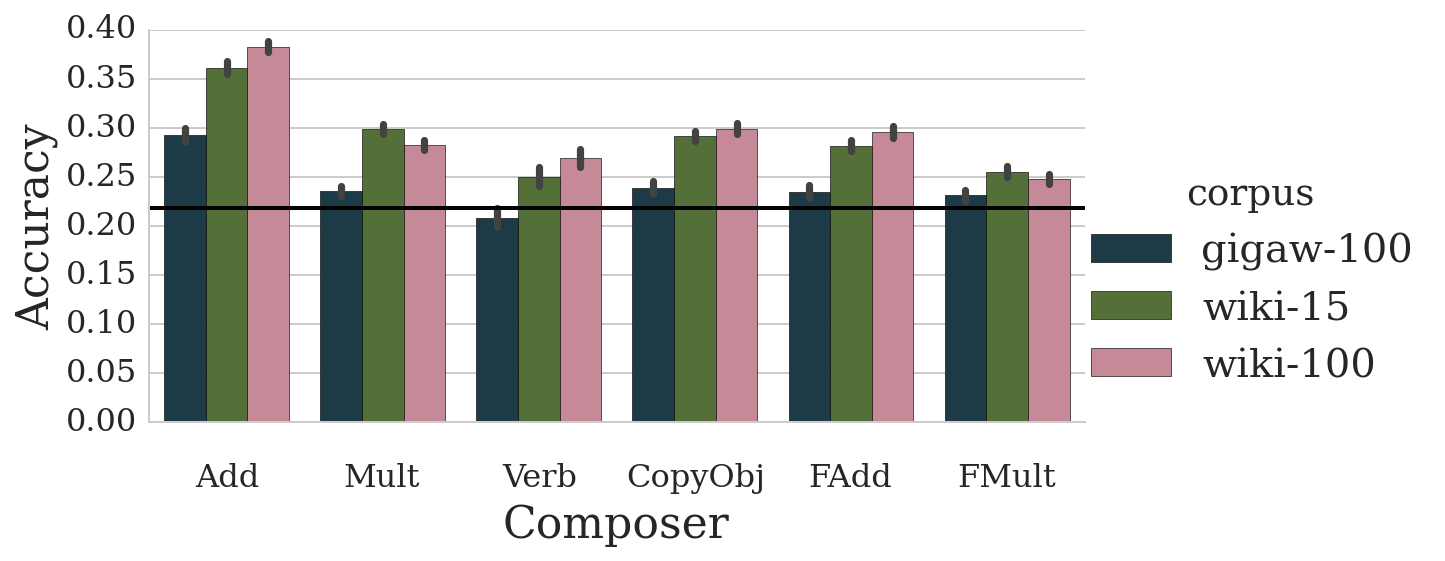

In [3]:
fields = {  'unlab': 'expansions__vectors__unlabelled',
            'algo': 'expansions__vectors__algorithm',
            'Composer': 'expansions__vectors__composer',
             'percent': 'expansions__vectors__unlabelled_percentage'}
df = dataframe_from_exp_ids(ids, fields)
df['corpus'] = ['%s-%s'%(a,b) for a,b in zip(df.unlab, df.percent)]
df.drop(['unlab', 'percent'], axis=1, inplace=True)
with sns.color_palette("cubehelix", 4):
    g= sns.factorplot(y='Accuracy', x='Composer', hue='corpus',# col='unlab', 
                      hue_order=sort_df_by(df, 'corpus'), aspect=2,
                        data=df, kind='bar', ci=68);

for ax in g.axes.flat:
    ax.axhline(random_vect_baseline(), c='k');
#     ax.axhline(nondistributional_baseline(**settings_of(ids[0])), c='k')

plt.axhline(random_vect_baseline(), c='k')
plt.savefig('plot-vps-corpus-size.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

# w2v vs glove vs count @ wiki 100

[220, 221, 222, 225, 226, 227, 230, 231, 232, 235, 236, 237, 314, 315, 316, 319, 320, 321] total 18
Accuracy has 9000 values
folds has 9000 values
algo has 9000 values
Composer has 9000 values


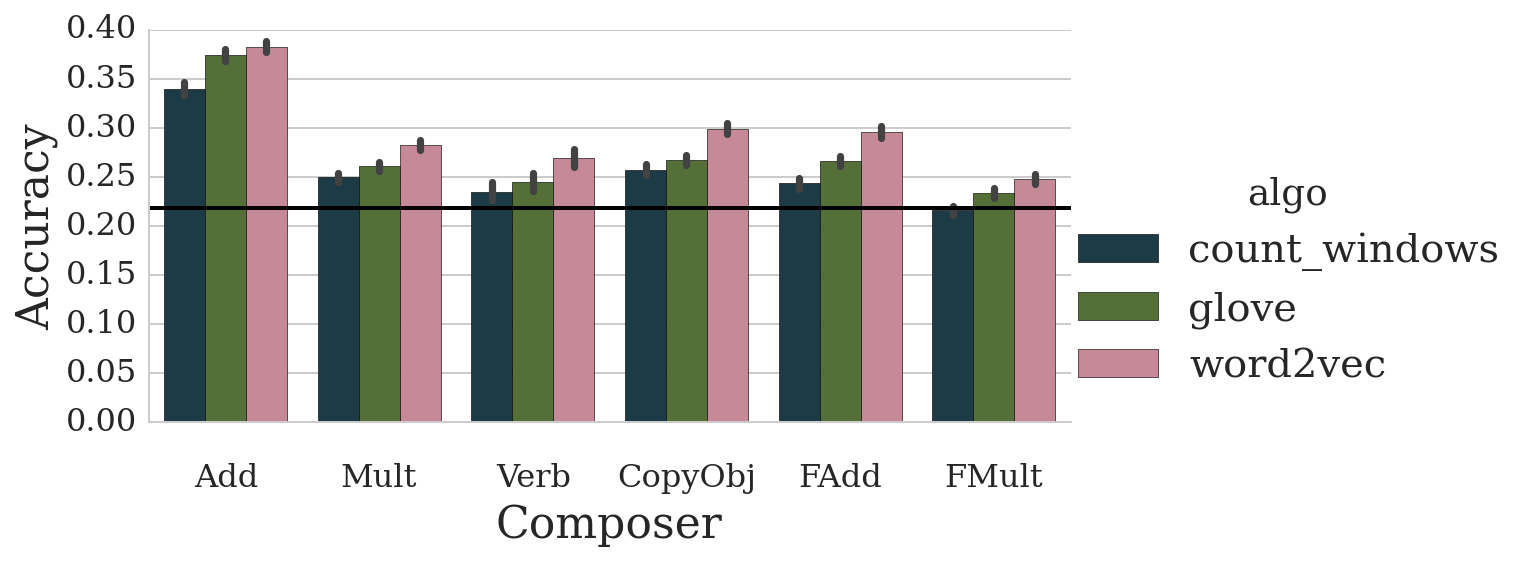

In [4]:
s['expansions__vectors__algorithm__in'] = ['word2vec', 'glove', 'count_windows']
s['expansions__vectors__composer__in'] = ['Verb', 'CopyObj', 'Add', 'Mult', 'FAdd', 'FMult']
s['expansions__vectors__unlabelled'] = 'wiki'
s['expansions__vectors__unlabelled_percentage__in'] = [100]
ids = Experiment.objects.filter(**s).values_list('id', flat=True)
print(ids, 'total', len(ids))

fields = {'algo': 'expansions__vectors__algorithm',
          'Composer': 'expansions__vectors__composer'
}
df = dataframe_from_exp_ids(ids, fields, abbreviate=False)
with sns.color_palette("cubehelix", 4):
    g= sns.factorplot(y='Accuracy', x='Composer', hue='algo', 
                       data=df, kind='bar', aspect=2, ci=68);
plt.axhline(random_vect_baseline(), c='k')
plt.savefig('plot-vps-algorithm.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

# Some coverage stats 

In [39]:
import re
from collections import defaultdict
from scipy.stats import mode

start_pattern = re.compile('Found a DF of shape .*? in HDF file (.*)')
count_pattern = re.compile('Training matrix for (.*?) from (\d+) SVOs')
d = defaultdict(list)

# log file produced by running categorical_composers.py
with open('../FeatureExtractionToolkit/categorical/categorical.o6208386.txt') as infile:
    curr_vectors = 'WTF'
    for line in infile:
        line = line.strip()
        match = re.search(start_pattern, line)
        if match:
            curr_vectors = match.groups()[0]

        match = re.search(count_pattern, line)
        if match:
            count = int(match.groups()[1])
            if count > 500 and 'glove' in curr_vectors:
                print(match.groups(0))
            d[curr_vectors].append(count)
        

('contain/V', '791')
('feature/V', '658')
('include/V', '2898')
('make/V', '1200')
('play/V', '886')
('provide/V', '676')
('receive/V', '859')
('use/V', '513')
('win/V', '1371')


In [35]:
for key, val in d.items():
    print(key)
    print(pd.Series(val).describe())
    print(np.mean(val), np.percentile(val, 2.5), np.percentile(val, 97.5), np.sum(val))
    print('median',np.median(val), 'mode', mode(val)[0][0])

('/lustre/scratch/inf/mmb28/FeatureExtractionToolkit/word2vec_vectors/word2vec-wiki-100perc.unigr.strings.rep0',)
count     549.000000
mean       50.132969
std       170.774798
min         3.000000
25%         5.000000
50%        10.000000
75%        35.000000
max      2898.000000
dtype: float64
50.1329690346 3.0 293.3 27523
median 10.0 mode 3
('/lustre/scratch/inf/mmb28/FeatureExtractionToolkit/exp11-13b-ppmi/exp11-with-obs-phrases-SVD100.events.filtered.strings',)
count     548.000000
mean       50.151460
std       170.749699
min         3.000000
25%         5.000000
50%        10.000000
75%        35.000000
max      2894.000000
dtype: float64
50.151459854 3.0 293.325 27483
median 10.0 mode 3
('/lustre/scratch/inf/mmb28/FeatureExtractionToolkit/word2vec_vectors/word2vec-wiki-15perc.unigr.strings.rep0',)
count     542.000000
mean       50.105166
std       169.983923
min         3.000000
25%         5.000000
50%        10.000000
75%        34.750000
max      2871.000000
dtype: float64


# Qualitative analysis 

In [132]:
from discoutils.thesaurus_loader import Vectors as vv
import random
v1 = vv.from_tsv('../FeatureExtractionToolkit/categorical/AN_NN_wiki-w2v-100_CopyObj.events.filtered.strings', allow_lexical_overlap=False)
v2 = vv.from_tsv('../FeatureExtractionToolkit/word2vec_vectors/composed/AN_NN_word2vec-wiki_100percent-rep0_Add.events.filtered.strings', allow_lexical_overlap=False)

In [138]:
from discoutils.tokens import DocumentFeature
vocab1 = []
for x in v1.keys():
    doc_feat = DocumentFeature.from_string(x)
    if doc_feat.type in ['SVO'] or (doc_feat.type=='1-GRAM' and doc_feat.tokens[0].pos in 'NJV'):
        vocab1.append(x)
        
v1.init_sims(n_neighbors=75, vocab=vocab1)
v2.init_sims(n_neighbors=75, vocab=vocab1)

In [139]:
random.seed(0)
words = random.sample([x for x in v1.keys() if x.count('_')], 15)
df = compare_neighbours([v1, v2], ['copyobj', 'add'], words)
df

,copyobj,add
seller/N_sell/V_bottle/N,"government/N_face/V_obstacle/N, money/N_buy/V_brand/N, buyer/N_enjoy/V_flexibilit...","product/N_buy/V_bag/N, wax/N_buy/V_product/N, item/N_buy/V_bag/N, product/N_buy/V..."
kit/N_contain/V_length/N,"model/N_feature/V_strip/N, version/N_use/V_concentrate/N, design/N_feature/V_qual...","description/N_include/V_diameter/N, box/N_encompass/V_size/N, valve/N_cover/V_set..."
japan/N_face/V_deterioration/N,"taiwan/N_introduce/V_cut/N, korea/N_maintain/V_surplus/N, china/N_manufacture/V_g...","instability/N, repercussion/N, damage/N, underfunding/N"
age/N_create/V_sense/N,"child/N_share/V_information/N, time/N_leave/V_reply/N, parent/N_save/V_money/N, c...","nuance/N, nature/N_make/V_time/N, understanding/N, set/N_explore/V_life/N"
scene/N_indicate/V_coincidence/N,"effect/N_live/V_footage/N, nature/N_match/V_character/N, presence/N_spark/V_laugh...","conversation/N_highlight/V_fact/N, sequence/N_suggest/V_girl/N, surprising/J, act..."
lucy/N_love/V_backpack/N,None,None
spirit/N_possess/V_dora/N,"nanjundaswami/N, fit/N_fit/V_factory/N, million/N_accredit/V_growth/N, elite/N_tr...","angelic/J, virginal/J, bewitching/J, saintly/J"
movie/N_lack/V_empathy/N,"film/N_demand/V_attention/N, filmmaker/N_round/V_suspect/N, cinema/N_constitute/V...",dubbing/N_provide/V_humor/N
character/N_lie/V_ass/N,"dalton/N_possess/V_charm/N, macbeth/N_possess/V_direction/N, borden/N_possess/V_w...","face/N_include/V_liar/N, love/N_run/V_face/N, heaven/N_cover/V_face/N, stinker/N_..."
squibb/N_sell/V_drug/N,"akzo/N_acquire/V_activity/N, ciba-geigy/N_acquire/V_pct/N, design/N_build/V_desig...","products/N_buy/V_product/N, pfizer/N, novartis/N, glaxosmithkline/N"


In [141]:
v1.get_nearest_neighbours('contain/V')[:5]

[('comprise/V', 1.5477013535350002),
 ('include/V', 1.6698707894098133),
 ('cyathus/N', 1.8171457165379661),
 ('syntype/N', 1.8546224989225495),
 ('foldout/J', 1.8676520323658903)]

In [142]:
v1.get_nearest_neighbours('receive/V')[:5]

[('earn/V', 1.5132787676618369),
 ('obtain/V', 1.7022099370610582),
 ('gain/V', 1.7691135155068585),
 ('garner/V', 1.8197497463680297),
 ('give/V', 1.8584883587897192)]

In [143]:
v2.get_nearest_neighbours('contain/V')[:5]

[('comprise/V', 1.5477013535350002),
 ('include/V', 1.6698707894098133),
 ('cyathus/N', 1.8171457165379661),
 ('syntype/N', 1.8546224989225495),
 ('foldout/J', 1.8676520323658903)]

In [144]:
pd.set_option('display.max_colwidth', 85)
print(pd.DataFrame(df.copyobj).to_latex())

\begin{tabular}{ll}
\toprule
{} &                                                                               copyobj \\
\midrule
seller/N\_sell/V\_bottle/N         &  government/N\_face/V\_obstacle/N, money/N\_buy/V\_brand/N, buyer/N\_enjoy/V\_flexibilit... \\
kit/N\_contain/V\_length/N         &  model/N\_feature/V\_strip/N, version/N\_use/V\_concentrate/N, design/N\_feature/V\_qual... \\
japan/N\_face/V\_deterioration/N   &  taiwan/N\_introduce/V\_cut/N, korea/N\_maintain/V\_surplus/N, china/N\_manufacture/V\_g... \\
age/N\_create/V\_sense/N           &  child/N\_share/V\_information/N, time/N\_leave/V\_reply/N, parent/N\_save/V\_money/N, c... \\
scene/N\_indicate/V\_coincidence/N &  effect/N\_live/V\_footage/N, nature/N\_match/V\_character/N, presence/N\_spark/V\_laugh... \\
lucy/N\_love/V\_backpack/N         &                                                                                  None \\
spirit/N\_possess/V\_dora/N        &  nanjundaswami/N, fit/N\_fit/V\_factory/N, mi

In [124]:
print(pd.DataFrame(df['add']).to_latex())

\begin{tabular}{ll}
\toprule
{} &                                                                                   add \\
\midrule
seller/N\_sell/V\_bottle/N         &  seller/N\_sell/V\_bag/N, seller/N\_sell/V\_powder/N, seller/N\_sell/V\_perfume/N, selle... \\
kit/N\_contain/V\_length/N         &  kit/N\_contain/V\_size/N, description/N\_include/V\_length/N, kit/N\_contain/V\_tube/N,... \\
japan/N\_face/V\_deterioration/N   &  deterioration/N, japan/N\_reduce/V\_barrier/N, japan/N\_raise/V\_fear/N, market/N\_exp... \\
age/N\_create/V\_sense/N           &  transference/N\_make/V\_age/N, age/N\_bring/V\_wisdom/N, beginning/N\_make/V\_sense/N, ... \\
scene/N\_indicate/V\_coincidence/N &  fact/N\_contain/V\_scene/N, pop/N\_indicate/V\_flaw/N, coincidence/N, viciousness/N\_i... \\
lucy/N\_love/V\_backpack/N         &  daughter/N\_love/V\_backpack/N, son/N\_love/V\_backpack/N, chloe/N\_love/V\_toy/N, emma... \\
spirit/N\_possess/V\_dora/N        &  dalton/N\_possess/V\_charm/N, spirit/N, 

# Why are neighbours almost always of the same type? 

In [125]:
some_unigrams = v1.matrix[:200, :]
some_vps = v1.matrix[-200:, :]
uni_norms = np.linalg.norm(some_unigrams, axis=1)
vp_norms = np.linalg.norm(some_vps, axis=1)

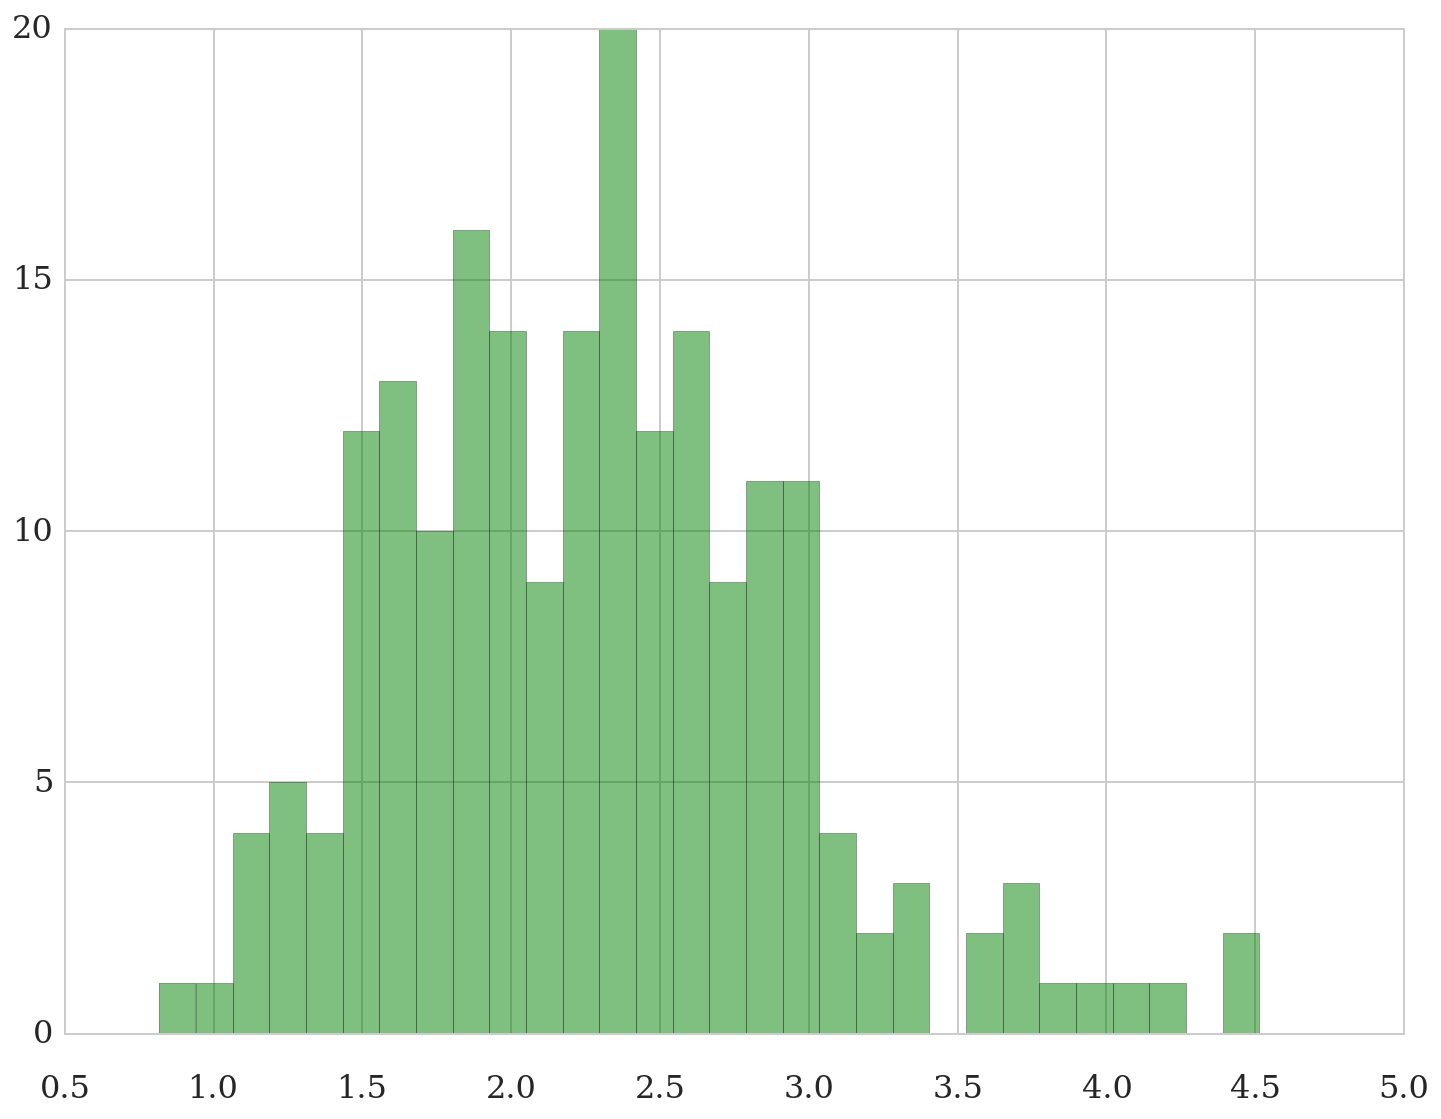

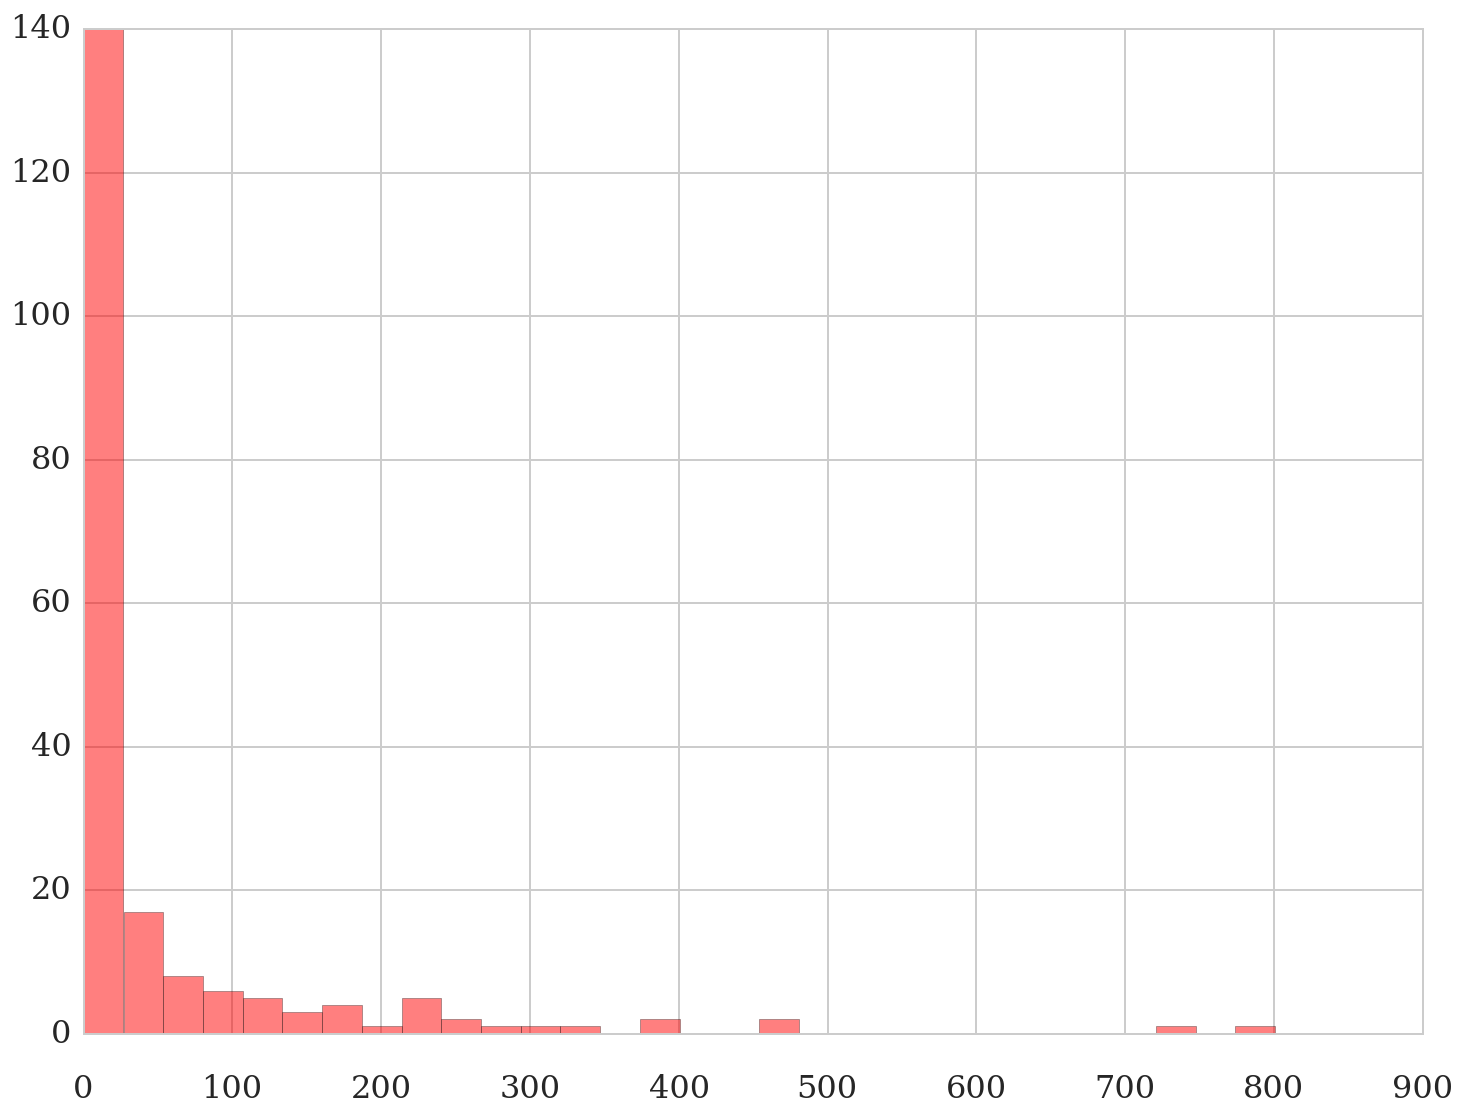

In [126]:
plt.hist(uni_norms, bins=30, color='g', alpha=0.5);
plt.figure()
plt.hist(vp_norms, bins=30, color='r', alpha=0.5);

# VP vectors are much longer than verb vectors
This can explain why VPs are always neighbours of other VPs. Let's scale all vectors to unit length and repeat.

In [127]:
from sklearn import preprocessing
from discoutils.thesaurus_loader import DenseVectors

x_scaled = preprocessing.normalize(v1.df.values)
scaled_df = pd.DataFrame(x_scaled, index=v1.df.index, columns=v1.df.columns)

v3 = DenseVectors(scaled_df, allow_lexical_overlap=True)

In [128]:
v3.init_sims(n_neighbors=5, vocab=vocab1)

In [129]:
v3.get_nearest_neighbours('squibb/N_sell/V_drug/N')

[('squibb/N_announce/V_agreement/N', 0.81652464402162195),
 ('akzo/N_acquire/V_activity/N', 0.89185742703176418),
 ('goldman/N_sell/V_stake/N', 0.90812578450068049),
 ('reebok/N_sell/V_share/N', 0.91730026354364314),
 ('design/N_sell/V_building/N', 0.92290893716475619)]

In [130]:
v3.get_nearest_neighbours('sell/V')

[('resell/V', 0.56398474040063684),
 ('buy/V', 0.56692984743173813),
 ('purchase/V', 0.62988424596379633),
 ('ship/V', 0.73134571071637688),
 ('auction/V', 0.74818050003469483)]

# Same thing really :( 